In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import roc_curve, RocCurveDisplay ,classification_report, confusion_matrix, accuracy_score, r2_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')


C:\Users\Abdul\AppData\Local\Temp\ipykernel_11120\2755838077.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
events = pd.read_csv('events.csv')
info = pd.read_csv('ginf.csv')

Preprocessing

In [3]:
events = events.merge(info[['id_odsp', 'country', 'date']], on='id_odsp', how='left')

In [4]:
extract_year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
events['year'] = [extract_year(x) for key, x in enumerate(events['date'])]

In [5]:
shots = events[events.event_type==1]


In [6]:
shots

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,year
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,2.0,0,9.0,2.0,1,1.0,0,germany,2011-08-05,2011
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,...,2.0,0,15.0,1.0,1,1.0,0,germany,2011-08-05,2011
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,...,1.0,1,9.0,2.0,1,1.0,0,germany,2011-08-05,2011
14,UFot0hit/,UFot0hit15,15,19,Attempt blocked. Mats Hummels (Borussia Dortmu...,1,NaN,1,Borussia Dortmund,Hamburg SV,...,3.0,0,15.0,1.0,0,1.0,0,germany,2011-08-05,2011
17,UFot0hit/,UFot0hit18,18,20,Attempt blocked. Tomas Rincon (Hamburg) right ...,1,NaN,2,Hamburg SV,Borussia Dortmund,...,3.0,0,15.0,1.0,0,1.0,0,germany,2011-08-05,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940983,z5L2OT5E/,z5L2OT5E102,102,81,Attempt blocked. Remo Freuler (Atalanta) right...,1,NaN,1,Atalanta,Sampdoria,...,3.0,0,15.0,1.0,0,1.0,0,italy,2017-01-22,2017
940991,z5L2OT5E/,z5L2OT5E110,110,84,Attempt missed. Alberto Grassi (Atalanta) righ...,1,12.0,1,Atalanta,Sampdoria,...,2.0,0,15.0,1.0,1,1.0,0,italy,2017-01-22,2017
940992,z5L2OT5E/,z5L2OT5E111,111,86,Attempt saved. Alejandro Gomez (Atalanta) righ...,1,12.0,1,Atalanta,Sampdoria,...,1.0,0,9.0,1.0,1,1.0,0,italy,2017-01-22,2017
940993,z5L2OT5E/,z5L2OT5E112,112,87,Attempt saved. Fabio Quagliarella (Sampdoria) ...,1,12.0,2,Sampdoria,Atalanta,...,1.0,0,15.0,1.0,1,1.0,0,italy,2017-01-22,2017


In [7]:
#Possible outcomes of a shot

pie = shots[['shot_outcome', 'id_event']].groupby('shot_outcome').count().reset_index().rename(columns={'id_event': 'count'})

In [8]:
pie

,shot_outcome,count
0,1.0,78014
1,2.0,92827
2,3.0,54082
3,4.0,3575


In [9]:
pie.shot_outcome = pie.shot_outcome.astype(int)
pie.shot_outcome = pie.shot_outcome.replace({1: 'On Target', 2: 'Off Target', 3: 'Blocked', 4: 'Hit the Bar'})

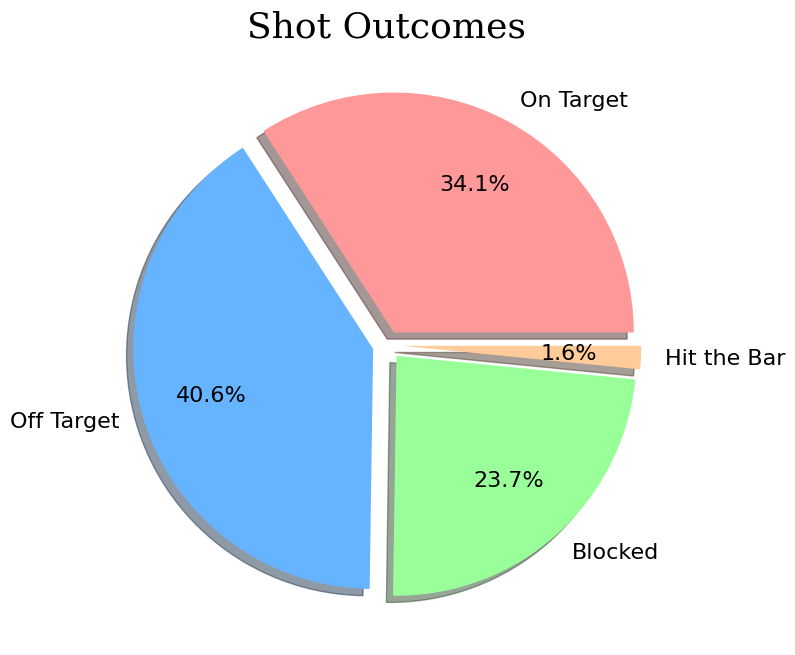

In [10]:
fig, ax = plt.subplots(figsize=[8,8])
labels = pie['shot_outcome']
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
plt.pie(x=pie['count'], autopct="%.1f%%", labels=labels, explode=[0.06]*4, pctdistance=0.7, colors=colors, shadow=True, \
       textprops=dict(fontsize=16))
plt.title("Shot Outcomes", fontsize=26, fontfamily='serif')
plt.tight_layout()
plt.show()

In [11]:
goals  = shots[['is_goal', 'id_event', 'country']].groupby(['is_goal', 'country']).count().reset_index().rename(columns={'id_event': 'count'})
goals.is_goal = goals.is_goal.replace({1: 'Goal', 0: 'No Goal'}) 


In [12]:
goals['percentage']=0
for i in range(len(goals)):
    for country in goals.country.unique():
        if goals.iloc[i,goals.columns.get_loc("country")]==country:
            goals.iloc[i,goals.columns.get_loc("percentage")]=goals.iloc[i,goals.columns.get_loc("count")] / \
                                                            goals[goals.country==country]['count'].sum()
goals['percentage']=round(goals['percentage']*100,2)

In [13]:
goals

,is_goal,country,count,percentage
0,No Goal,england,30360,89.53
1,No Goal,france,43795,89.39
2,No Goal,germany,36916,88.87
3,No Goal,italy,49253,89.97
4,No Goal,spain,44370,88.83
5,Goal,england,3552,10.47
6,Goal,france,5199,10.61
7,Goal,germany,4621,11.13
8,Goal,italy,5491,10.03
9,Goal,spain,5578,11.17


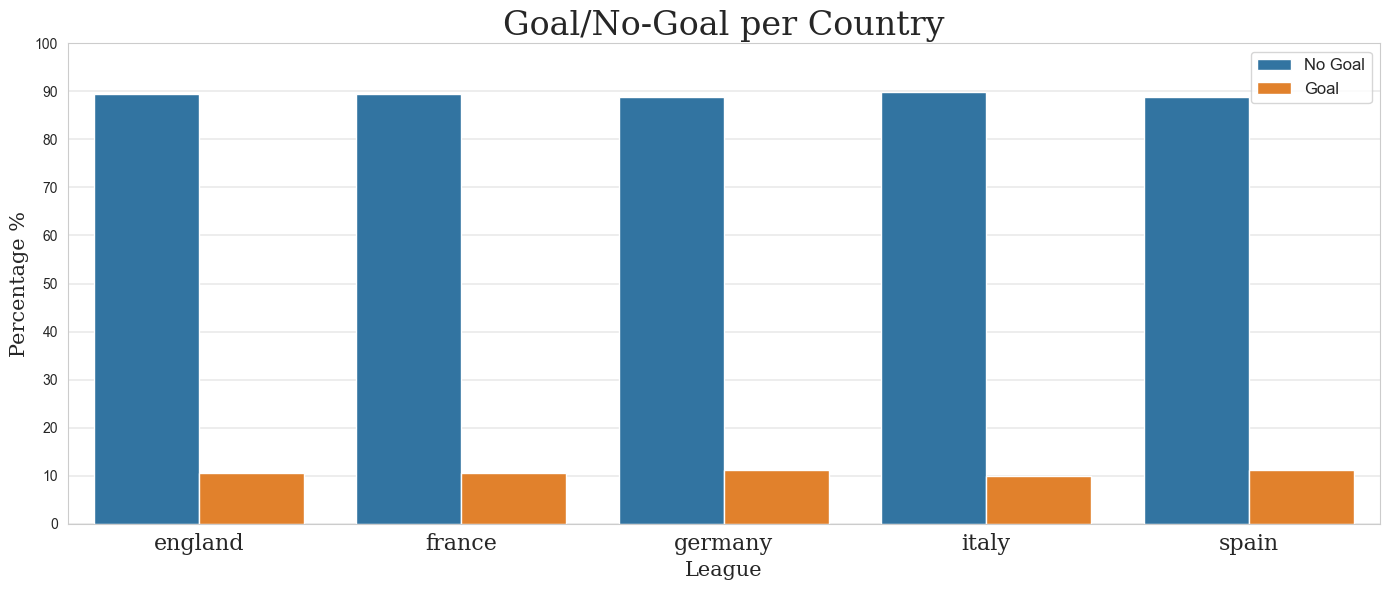

In [14]:
sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=[14,6])
colors = ['#ff9999','#66b3ff','#99ff99','#ffcc99']
ax = sns.barplot(data=goals, y='percentage', hue='is_goal', x='country')
ax.set_yticks(np.arange(0,110,10))
ax.set_ylabel(ylabel='Percentage %', fontsize=15, fontfamily='serif')
ax.set_xlabel(xlabel='League', fontsize=15, fontfamily='serif')
ax.set_xticklabels(labels=ax.get_xticklabels(), fontsize=16, fontfamily='serif')
plt.title("Goal/No-Goal per Country", fontsize=24, fontfamily='serif')
plt.tight_layout()
ax.grid(color='black', linestyle='-', linewidth=0.1, axis='y')
plt.legend(fontsize=12)
#show_values_on_bars(ax)
plt.show()

In [15]:
shots.isna().sum()

id_odsp               0
id_event              0
sort_order            0
time                  0
text                  0
event_type            0
event_type2       60575
side                  0
event_team            0
opponent              0
player               13
player2           61337
player_in        229135
player_out       229135
shot_place         1683
shot_outcome        637
is_goal               0
location              0
bodypart              0
assist_method         0
situation             0
fast_break            0
country               0
date                  0
year                  0
dtype: int64

In [16]:
shots

,id_odsp,id_event,sort_order,time,text,event_type,event_type2,side,event_team,opponent,...,shot_outcome,is_goal,location,bodypart,assist_method,situation,fast_break,country,date,year
0,UFot0hit/,UFot0hit1,1,2,Attempt missed. Mladen Petric (Hamburg) left f...,1,12.0,2,Hamburg SV,Borussia Dortmund,...,2.0,0,9.0,2.0,1,1.0,0,germany,2011-08-05,2011
11,UFot0hit/,UFot0hit12,12,14,Attempt missed. Shinji Kagawa (Borussia Dortmu...,1,12.0,1,Borussia Dortmund,Hamburg SV,...,2.0,0,15.0,1.0,1,1.0,0,germany,2011-08-05,2011
13,UFot0hit/,UFot0hit14,14,17,"Goal! Borussia Dortmund 1, Hamburg 0. Kevin G...",1,12.0,1,Borussia Dortmund,Hamburg SV,...,1.0,1,9.0,2.0,1,1.0,0,germany,2011-08-05,2011
14,UFot0hit/,UFot0hit15,15,19,Attempt blocked. Mats Hummels (Borussia Dortmu...,1,NaN,1,Borussia Dortmund,Hamburg SV,...,3.0,0,15.0,1.0,0,1.0,0,germany,2011-08-05,2011
17,UFot0hit/,UFot0hit18,18,20,Attempt blocked. Tomas Rincon (Hamburg) right ...,1,NaN,2,Hamburg SV,Borussia Dortmund,...,3.0,0,15.0,1.0,0,1.0,0,germany,2011-08-05,2011
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
940983,z5L2OT5E/,z5L2OT5E102,102,81,Attempt blocked. Remo Freuler (Atalanta) right...,1,NaN,1,Atalanta,Sampdoria,...,3.0,0,15.0,1.0,0,1.0,0,italy,2017-01-22,2017
940991,z5L2OT5E/,z5L2OT5E110,110,84,Attempt missed. Alberto Grassi (Atalanta) righ...,1,12.0,1,Atalanta,Sampdoria,...,2.0,0,15.0,1.0,1,1.0,0,italy,2017-01-22,2017
940992,z5L2OT5E/,z5L2OT5E111,111,86,Attempt saved. Alejandro Gomez (Atalanta) righ...,1,12.0,1,Atalanta,Sampdoria,...,1.0,0,9.0,1.0,1,1.0,0,italy,2017-01-22,2017
940993,z5L2OT5E/,z5L2OT5E112,112,87,Attempt saved. Fabio Quagliarella (Sampdoria) ...,1,12.0,2,Sampdoria,Atalanta,...,1.0,0,15.0,1.0,1,1.0,0,italy,2017-01-22,2017


In [17]:
shots.drop(['player_out','player_in'],axis=1,inplace=True)

In [18]:
shots.isna().sum()

id_odsp              0
id_event             0
sort_order           0
time                 0
text                 0
event_type           0
event_type2      60575
side                 0
event_team           0
opponent             0
player              13
player2          61337
shot_place        1683
shot_outcome       637
is_goal              0
location             0
bodypart             0
assist_method        0
situation            0
fast_break           0
country              0
date                 0
year                 0
dtype: int64

In [19]:
shots.info()

<class 'pandas.core.frame.DataFrame'>
Index: 229135 entries, 0 to 941006
Data columns (total 23 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   id_odsp        229135 non-null  object 
 1   id_event       229135 non-null  object 
 2   sort_order     229135 non-null  int64  
 3   time           229135 non-null  int64  
 4   text           229135 non-null  object 
 5   event_type     229135 non-null  int64  
 6   event_type2    168560 non-null  float64
 7   side           229135 non-null  int64  
 8   event_team     229135 non-null  object 
 9   opponent       229135 non-null  object 
 10  player         229122 non-null  object 
 11  player2        167798 non-null  object 
 12  shot_place     227452 non-null  float64
 13  shot_outcome   228498 non-null  float64
 14  is_goal        229135 non-null  int64  
 15  location       229135 non-null  float64
 16  bodypart       229135 non-null  float64
 17  assist_method  229135 non-null  in

In [20]:
#Selecting important features for xG

Selected_features = shots[['location','assist_method','bodypart','situation','fast_break','is_goal']]
Selected_features

,location,assist_method,bodypart,situation,fast_break,is_goal
0,9.0,1,2.0,1.0,0,0
11,15.0,1,1.0,1.0,0,0
13,9.0,1,2.0,1.0,0,1
14,15.0,0,1.0,1.0,0,0
17,15.0,0,1.0,1.0,0,0
...,...,...,...,...,...,...
940983,15.0,0,1.0,1.0,0,0
940991,15.0,1,1.0,1.0,0,0
940992,9.0,1,1.0,1.0,0,0
940993,15.0,1,1.0,1.0,0,0


Model

In [21]:
X = Selected_features.drop('is_goal',axis=1)
y = Selected_features['is_goal']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, random_state=1)

In [22]:
#getting N_neighbors
import math
math.sqrt(len(y_test))

283.19251402535343

In [23]:
models = {
    'Logistic Regression': LogisticRegression(),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'SVM': SVC(kernel='rbf'),
    'KNN': KNeighborsClassifier(n_neighbors = 283, p = 2, metric = 'euclidean'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'XGBoost': XGBClassifier(),
    'Naive Bayes': GaussianNB(),
    
}

for name, model in models.items():
    print(f"Training {name}...")
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    print(f"{name} Accuracy: {accuracy:.2f}")
    print("\n")
    print(f"{name} R2_Score: {r2:.2f}")
    print("\n")
    print(classification_report(y_test, y_pred))
    print("\n")

Training Logistic Regression...
Logistic Regression Accuracy: 0.89


Logistic Regression R2_Score: -0.12


              precision    recall  f1-score   support

           0       0.89      1.00      0.94     71694
           1       0.76      0.00      0.01      8504

    accuracy                           0.89     80198
   macro avg       0.82      0.50      0.48     80198
weighted avg       0.88      0.89      0.84     80198



Training Decision Tree...
Decision Tree Accuracy: 0.91


Decision Tree R2_Score: 0.06


              precision    recall  f1-score   support

           0       0.92      0.99      0.95     71694
           1       0.71      0.27      0.39      8504

    accuracy                           0.91     80198
   macro avg       0.81      0.63      0.67     80198
weighted avg       0.90      0.91      0.89     80198



Training Random Forest...
Random Forest Accuracy: 0.91


Random Forest R2_Score: 0.06


              precision    recall  f1-score   support

    

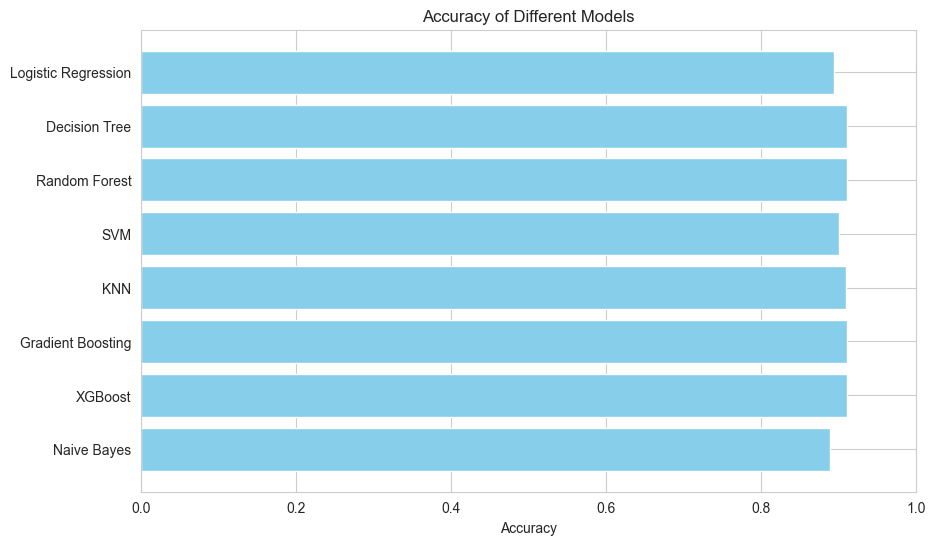

In [24]:
# Dictionary to store accuracies
accuracies = {}

for name, model in models.items():
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    accuracies[name] = accuracy

# Create a bar plot for accuracies
plt.figure(figsize=(10, 6))
plt.barh(list(accuracies.keys()), list(accuracies.values()), color='skyblue')
plt.xlabel('Accuracy')
plt.title('Accuracy of Different Models')
plt.xlim(0, 1)
plt.gca().invert_yaxis() 
plt.show()

In [25]:
param_grid = {
    'n_estimators' :[50, 100, 150, 200],
    'max_depth' :[None, 30, 50, 70],
    'min_samples_split' :[2,5,7,10],
    'max_features' :['sqrt','log2']
}



In [26]:
model = RandomForestClassifier(random_state=90)
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, n_jobs=1)

grid_search.fit(X_train, y_train)

print(f"Best parameters: {grid_search.best_params_}")

rf = grid_search.best_estimator_



Best parameters: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_split': 7, 'n_estimators': 100}


In [27]:
y_pred =rf.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

0.9108830644155714


Evaluation

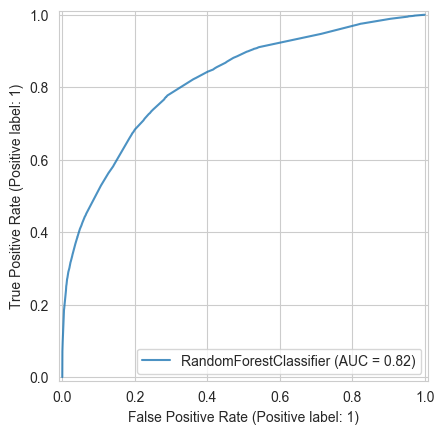

In [28]:
# Calculate predicted probabilities
y_pred_proba = rf.predict_proba(X_test)[:, 1] # binary classification

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_proba)

# Create ROC curve plot
RocCurveDisplay.from_estimator(rf, X_test, y_test, alpha=0.8)
plt.show()

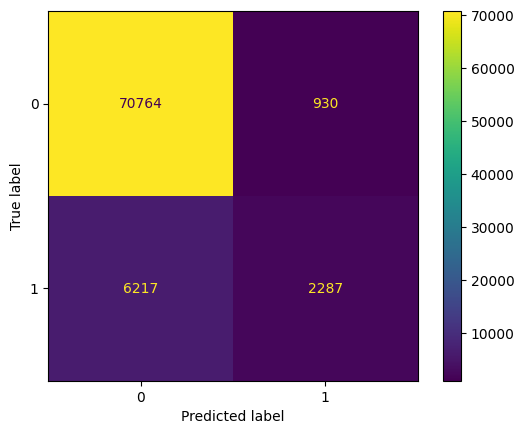

In [29]:
sns.reset_orig() 
cm = confusion_matrix(y_test, y_pred, labels=rf.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=rf.classes_)
disp.plot()
plt.show()

In [30]:
shots['prediction'] = rf.predict_proba(X)[:, 1]
shots['difference'] = shots['prediction'] - shots['is_goal']

In [31]:
players = shots.groupby('player').sum().reset_index()
players.rename(columns={'is_goal': 'trueGoals', 'prediction': 'expectedGoals'}, inplace=True)
players.expectedGoals = round(players.expectedGoals,2)
players.difference = round(players.difference,2)
players['ratio'] = players['trueGoals'] / players['expectedGoals']

In [32]:
show = players.sort_values(['difference', 'trueGoals']).reset_index(drop=True)
show['rank'] = show.index+1
show = show[['rank', 'player', 'difference', 'trueGoals', 'expectedGoals']].head(10)
show.head(10)

,rank,player,difference,trueGoals,expectedGoals
0,1,lionel messi,-58.50,205,146.50
1,2,zlatan ibrahimovic,-33.93,153,119.07
2,3,cristiano ronaldo,-32.33,198,165.67
3,4,gonzalo higuain,-32.06,118,85.94
4,5,luis suarez,-31.78,96,64.22
5,6,robert lewandowski,-27.21,124,96.79
6,7,alexandre lacazette,-24.78,88,63.22
7,8,alexis sanchez,-22.71,80,57.29
8,9,karim benzema,-21.70,85,63.30
9,10,antoine griezmann,-21.29,80,58.71


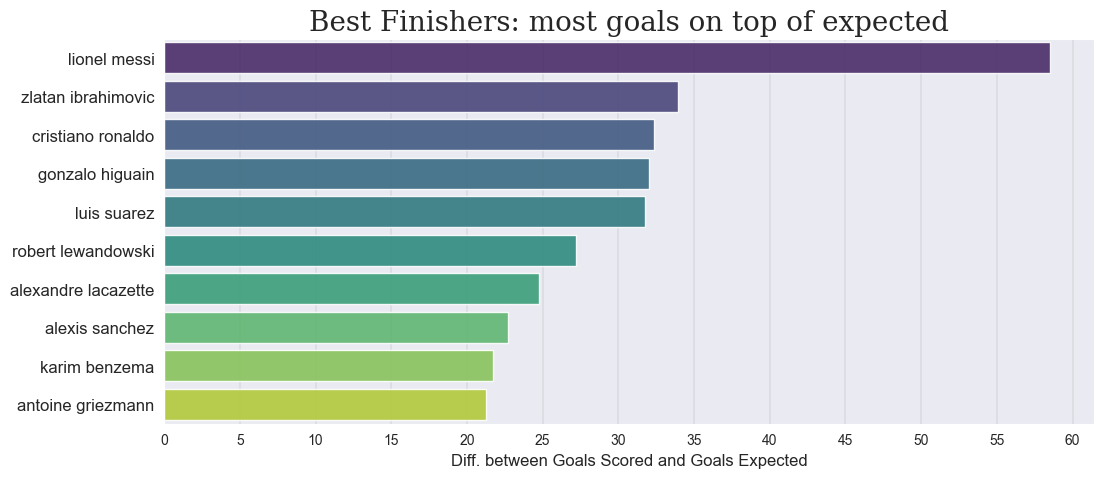

In [33]:
sns.set_style("dark")
fig, ax = plt.subplots(figsize=[12,5])
ax = sns.barplot(x=abs(show['difference']), y=show['player'], palette='viridis', alpha=0.9)
ax.set_xticks(np.arange(0,65,5))
ax.set_xlabel(xlabel='Diff. between Goals Scored and Goals Expected', fontsize=12)
ax.set_ylabel(ylabel='')
ax.set_yticklabels(labels=ax.get_yticklabels(), fontsize=12)
plt.title("Best Finishers: most goals on top of expected", fontsize=20, fontfamily='serif')
ax.grid(color='black', linestyle='-', linewidth=0.1, alpha=0.8, axis='x')
plt.show()

In [34]:
rs = np.random.RandomState(0)
corr = Selected_features.corr()
corr.style.background_gradient(cmap='coolwarm')

,location,assist_method,bodypart,situation,fast_break,is_goal
location,1.000000,-0.369691,-0.373770,-0.021526,-0.029610,-0.094401
assist_method,-0.369691,1.000000,0.279921,-0.040232,0.038369,0.039777
bodypart,-0.373770,0.279921,1.000000,0.182885,-0.036486,-0.000851
situation,-0.021526,-0.040232,0.182885,1.000000,-0.056683,0.088820
fast_break,-0.029610,0.038369,-0.036486,-0.056683,1.000000,0.116332
is_goal,-0.094401,0.039777,-0.000851,0.088820,0.116332,1.000000
